In [ ]:
!pip install ultralytics ensemble-boxes

In [ ]:
#Install libraries

import os
import glob
import cv2

from zipfile import ZipFile
import requests

import numpy as np
from PIL import Image

import torch
from ultralytics import YOLO

import matplotlib.pyplot as plt

from ensemble_boxes import weighted_boxes_fusion
from torchvision.ops import nms

**Download Dataset**

In [ ]:
# Download dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0]) # Unzip when downloaded.
            print("Done")
    except:
        print("Invalid file")

In [ ]:
SAMPLES_URL = f"https://www.dropbox.com/scl/fi/o2suoh5xwgzp7sy90buqt/test-samples.zip?rlkey=rr1yuy91tgli22k0d2i9y5kxa&dl=1"
SAMPLE_IMG_DIR = "test-samples"
SAMPLE_DATA_ZIP_FILE = os.path.join(os.getcwd(), f"{SAMPLE_IMG_DIR}.zip")

URL_MODEL_CKPTS = f"https://www.dropbox.com/scl/fi/6q4uhv7nj2ag2h742qmdv/yolov8-global-wheat-models.zip?rlkey=ythxu4v7kl7fhx4fgd9wp17gc&dl=1"
MODELS_DIR = "yolov8-global-wheat-models"
CKPTS_ZIP_FILE = os.path.join(os.getcwd(), f"{MODELS_DIR}.zip")

# Download if dataset does not exists.
if not os.path.exists(SAMPLE_IMG_DIR):
    download_and_unzip(SAMPLES_URL, SAMPLE_DATA_ZIP_FILE)
    os.remove(SAMPLE_DATA_ZIP_FILE)

if not os.path.exists(MODELS_DIR):
    download_and_unzip(URL_MODEL_CKPTS, CKPTS_ZIP_FILE)
    os.remove(CKPTS_ZIP_FILE)

**Utility to set resolution for each images**

In [ ]:
def get_data_resolution(image_dir_path, img_files):

    image_res = dict()

    for img_file in img_files:
        img_filepath = os.path.join(image_dir_path, img_file)

        image_id = img_file.strip().split(".")[0]
        image = Image.open(img_filepath)

        image_res[image_id] = image.size

    return image_res

**Create dictionaries for score, box, class**

In [ ]:
def get_predictions(model, image_dir_path, image_filenames, conf_thres=0.25):

    preds_scores = dict()
    pred_boxes = dict()
    pred_classes = dict()

    for image_file in image_filenames:

        img_filepath = os.path.join(image_dir_path, image_file)
        image_id = image_file.strip().split(".")[0]

        pred_results = model.predict(img_filepath, conf=conf_thres)[0].boxes.cpu()

        preds_scores[image_id] = pred_results.conf.unsqueeze(dim=1).numpy()
        pred_boxes[image_id]   = pred_results.xyxy.numpy()
        pred_classes[image_id] = pred_results.cls.int().unsqueeze(dim=1).numpy()

    return preds_scores, pred_boxes, pred_classes

In [ ]:
import os
model_dict = dict()

sample_img_files = os.listdir(SAMPLE_IMG_DIR)
data_res_dict = get_data_resolution(SAMPLE_IMG_DIR, sample_img_files)

print(data_res_dict)

ckpt_files = os.listdir(MODELS_DIR)


# Initialize Model Checkpoints.
for pt_file in ckpt_files:
    print(pt_file)
    model_dict["yolov8_"+pt_file.split("_")[1]] = YOLO(os.path.join(MODELS_DIR, pt_file))
    print(model_dict["yolov8_"+pt_file.split("_")[1]])


{'f5a1f0358': (1024, 1024), '348a992bb': (1024, 1024), 'cc3532ff6': (1024, 1024), '51b3e36ab': (1024, 1024)}
yolov8_l_best.pt
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(320, 128, 

In [ ]:
pred_confs   = []
pred_boxes   = []
pred_classes = []

for model_obj in model_dict.values():
    confs_scores, box_preds, cls_preds = get_predictions(model_obj, SAMPLE_IMG_DIR, sample_img_files)
    pred_confs.append(confs_scores)
    pred_boxes.append(box_preds)
    pred_classes.append(cls_preds)


image 1/1 /content/test-samples/f5a1f0358.jpg: 640x640 27 wheat_dets, 63.1ms
Speed: 14.2ms preprocess, 63.1ms inference, 19.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/348a992bb.jpg: 640x640 38 wheat_dets, 54.6ms
Speed: 2.7ms preprocess, 54.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/cc3532ff6.jpg: 640x640 27 wheat_dets, 54.6ms
Speed: 2.7ms preprocess, 54.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/51b3e36ab.jpg: 640x640 27 wheat_dets, 43.1ms
Speed: 2.9ms preprocess, 43.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/test-samples/f5a1f0358.jpg: 1024x1024 30 wheat_heads, 52.8ms
Speed: 3.3ms preprocess, 52.8ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)

image 1/1 /content/test-samples/348a992bb.jpg: 1024x1024 39 wheat_heads, 44.5ms
Speed: 3.4ms preprocess, 44.5ms infer

## **Ensemble Model Predictions**

**1. Perform Non-Maximum-Suppression (NMS)**
The `perform_non_max_suppression` utility is used to perform NMS across the model ensembles.

- `pred_confs_models`: the list of predicted confidence scores across the models.

- `pred_boxes_models`: the list of predicted bounding box coordinates across the models.

- `image_ids`: the list of Image IDs.

- `IOU_THRESH`: The IoU or NMS threshold.

- `FINAL_CONF_THRESH`: The confidence threshold to further filter out the boxes after NMS.

In [ ]:
def perform_non_max_suppression(
    pred_confs_models,
    pred_boxes_models,
    image_ids,
    IOU_THRESH,
    FINAL_CONF_THRESH=None):

    nms_boxes_dict = dict()
    nms_scores_dict = dict()

    for image_id in image_ids:

        all_model_boxes   = []
        all_model_scores  = []

        for boxes, scores in zip(pred_boxes_models, pred_confs_models):
            all_model_boxes.append(torch.from_numpy(boxes[image_id]))
            all_model_scores.append(torch.from_numpy(scores[image_id]))

        # Concatenate predicted bounding boxes and conf scores across all models.

        print("******** Before NMS ********")

        all_model_boxes = torch.cat(all_model_boxes)
        print(all_model_boxes)
        all_model_scores = torch.cat(all_model_scores).squeeze()
        print(all_model_scores)

        # Perform NMS on the predictions.
        # The variable 'keep' returns the indices of predictions that are retained
        # after NMS in decreasing order of conf. scores.
        keep = nms(
                boxes=all_model_boxes,
                scores=all_model_scores,
                iou_threshold=IOU_THRESH)

        # Obtain the filtered boxes and scores after NMS.
        boxes_retained = all_model_boxes[keep]
        scores_retained = all_model_scores[keep]

        print("******* After NMS ********")

        print(boxes_retained)
        print(scores_retained)

        # Further filter out boxes having scores > FINAL_CONF_THRESH.
        final_scores_ids = torch.where(scores_retained > FINAL_CONF_THRESH)[0]

        final_boxes = boxes_retained[final_scores_ids]
        final_scores = scores_retained[final_scores_ids]

        print("******* After THRESHOLD FILTER ********")

        print(final_boxes)
        print(final_scores)

        # Box cordinates in [xmin, ymin, width, height] format.
        final_boxes = final_boxes.int()
        final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]

        # Append final_boxes and final_scores in dictionaries mapped with IMAGE_IDs.
        nms_boxes_dict[image_id] = final_boxes.tolist()
        nms_scores_dict[image_id] = torch.unsqueeze(torch.round(final_scores, decimals=5), dim=-1).tolist()

        print("******* Final NMS Output ********")

        print(nms_boxes_dict)
        print(nms_scores_dict)

    return nms_boxes_dict, nms_scores_dict

In [ ]:
image_ids = list(data_res_dict.keys())

boxes_dict_nms, scores_dict_nms = perform_non_max_suppression(
                                    pred_confs,
                                    pred_boxes,
                                    image_ids,
                                    IOU_THRESH=0.50,
                                    FINAL_CONF_THRESH=0.28)

******** Before NMS ********
tensor([[5.4797e+02, 3.9537e+02, 6.2614e+02, 4.9897e+02],
        [9.4280e+02, 4.3191e+02, 1.0236e+03, 6.1660e+02],
        [5.4043e+02, 2.6914e+02, 6.5028e+02, 3.8552e+02],
        [6.6846e-02, 8.4046e+02, 6.7127e+01, 9.5847e+02],
        [2.2032e+02, 3.1047e+02, 3.4412e+02, 4.1744e+02],
        [6.0246e+02, 7.2663e+02, 7.0118e+02, 8.1709e+02],
        [8.8590e+02, 6.4080e+02, 9.7549e+02, 7.8515e+02],
        [6.5955e-02, 0.0000e+00, 6.4762e+01, 7.0813e+01],
        [4.4529e+02, 3.0266e+02, 5.5063e+02, 4.8746e+02],
        [1.3776e+02, 7.4895e+02, 2.9782e+02, 8.6578e+02],
        [6.9247e+02, 5.6289e+02, 7.7208e+02, 6.9886e+02],
        [6.8521e+02, 2.0344e+02, 8.0191e+02, 2.9607e+02],
        [2.9506e+02, 4.5747e+02, 4.4577e+02, 5.5971e+02],
        [2.5258e+02, 6.5777e+02, 3.5666e+02, 7.4256e+02],
        [3.9564e+02, 6.8258e+02, 4.9342e+02, 8.0591e+02],
        [6.6977e+02, 1.0997e+02, 7.4437e+02, 2.0131e+02],
        [1.5112e+02, 2.4326e+02, 2.3602e+02

**2. Weighted Boxes Fusion (WBF) for Ensembling Multi-Model Predictions**

**Weighted Boxes Fusion (WBF)** takes same paramters as **NMS** in addition to:
- `resolution_dict`: a dictionary mapping from Image IDs to its corresponding shape.
- `CONF_THRESH`: To exclude boxes with confidences lower than this threshold.

In [ ]:
def perform_weighted_boxes_fusion(
        pred_confs_models,
        pred_boxes_models,
        pred_classes_models,
        resolution_dict,
        IOU_THRESH=0.5,
        CONF_THRESH=None,
        FINAL_CONF_THRESH=1e-3):

    wbf_boxes_dict = dict()
    wbf_scores_dict = dict()

    for image_id, res in resolution_dict.items():

        res_array = np.array([res[1], res[0], res[1], res[0]]) # [W, H, W, H]

        all_model_boxes   = []
        all_model_scores  = []
        all_model_classes = []

        for boxes, scores, classes in zip(pred_boxes_models, pred_confs_models, pred_classes_models):

            # Normalize [xmin, ymin, xmax, ymax] in normalized form.
            pred_boxes_norm = (boxes[image_id] / res_array).clip(min=0., max=1.)
            scores_model = scores[image_id]
            classes_model = classes[image_id]

            all_model_boxes.append(pred_boxes_norm)
            all_model_scores.append(scores_model)
            all_model_classes.append(classes_model)

        # Perform weighted box fusion.
        boxes, scores, labels = weighted_boxes_fusion(
                                        all_model_boxes,
                                        all_model_scores,
                                        all_model_classes,
                                        weights=None,
                                        iou_thr=IOU_THRESH,
                                        skip_box_thr=CONF_THRESH)


        # Further filter out boxes having scores > FINAL_CONF_THRESH.
        final_scores_ids = np.where(scores > FINAL_CONF_THRESH)[0]

        final_boxes = boxes[final_scores_ids]
        final_scores = scores[final_scores_ids]

        # Box cordinates in [xmin, ymin, xmax, ymax] in de-normalized form.
        final_boxes = (final_boxes*res_array).clip(min=[0.,0.,0.,0.],
                                                   max=[res[1]-1, res[0]-1, res[1]-1, res[0]-1])

        final_boxes = final_boxes.astype("int")

        # Box cordinates in [xmin, ymin, width, height] in de-normalized form.
        final_boxes[:,2:] = final_boxes[:,2:] - final_boxes[:, :2]

        wbf_boxes_dict[image_id] = final_boxes.tolist()
        wbf_scores_dict[image_id] = np.expand_dims(np.round(final_scores, 5), axis=-1).tolist()


    return wbf_boxes_dict, wbf_scores_dict

In [ ]:
boxes_dict_wbf, scores_dict_wbf = perform_weighted_boxes_fusion(
                                    pred_confs,
                                    pred_boxes,
                                    pred_classes,
                                    data_res_dict,
                                    IOU_THRESH=0.50,
                                    CONF_THRESH=0.32,
                                    FINAL_CONF_THRESH=0.28)

In [ ]:
print(boxes_dict_wbf)
print(scores_dict_wbf)

{'f5a1f0358': [[943, 433, 80, 184], [548, 397, 77, 103], [541, 270, 111, 114], [222, 311, 122, 105], [293, 457, 155, 103], [884, 642, 89, 142], [0, 840, 67, 112], [689, 203, 112, 92], [135, 751, 163, 116], [602, 726, 100, 88], [0, 0, 68, 70], [691, 562, 80, 136], [251, 659, 105, 82], [669, 111, 74, 87], [149, 242, 84, 92], [812, 406, 97, 95], [396, 681, 96, 132], [411, 172, 70, 68], [483, 803, 119, 88], [90, 821, 62, 60], [445, 300, 105, 182], [521, 0, 115, 100], [129, 621, 70, 67], [64, 459, 130, 109], [228, 561, 80, 94], [295, 568, 83, 85], [755, 584, 98, 136], [404, 796, 101, 75]], '348a992bb': [[734, 220, 139, 86], [0, 314, 116, 94], [138, 37, 117, 86], [760, 115, 127, 88], [536, 30, 78, 97], [598, 442, 120, 97], [278, 329, 84, 95], [297, 162, 93, 98], [1, 470, 135, 92], [452, 651, 78, 81], [914, 562, 88, 95], [112, 929, 88, 71], [856, 847, 78, 70], [144, 600, 66, 62], [728, 476, 64, 77], [379, 215, 84, 80], [662, 386, 113, 73], [937, 784, 83, 82], [688, 42, 86, 91], [968, 669, 55,

**Visualize Predictions**

The `draw_bbox_conf utility` plots the bounding boxes and the confidence scores on the corresponding image.

In [ ]:
def draw_bbox_conf(image, boxes, scores, class_name, color=(255, 0, 0), thickness=-1):

    overlay = image.copy()

    font_size = 0.25 + 0.07 * min(overlay.shape[:2]) / 100
    font_size = max(font_size, 0.5)
    font_size = min(font_size, 0.8)
    text_offset = 7

    for box, score in zip(boxes, scores):
        xmin = box[0]
        ymin = box[1]
        xmax = box[0]+box[2]
        ymax = box[1]+box[3]

        overlay = cv2.rectangle(overlay,
                                (xmin, ymin),
                                (xmax, ymax),
                                color,
                                thickness)

        display_text = f"{class_name}: {score[0]:.2f}"

        (text_width, text_height), _ = cv2.getTextSize(display_text,
                                                       cv2.FONT_HERSHEY_SIMPLEX,
                                                       font_size, 2)

        cv2.rectangle(overlay,
                      (xmin, ymin),
                      (xmin + text_width + text_offset,
                       ymin - text_height - int(15 * font_size)),
                      color, thickness=-1)


        overlay = cv2.putText(
                    overlay,
                    display_text,
                    (xmin + text_offset, ymin - int(10 * font_size)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_size,
                    (255, 255, 255),
                    2, lineType=cv2.LINE_AA,
                )

    return cv2.addWeighted(overlay, 0.75, image, 0.25, 0)

In [ ]:
def visualize_boxes(root_dir, img_files, boxes_dict, scores_dict, plt_title):

    fig = plt.figure(figsize=(10, 25), layout="constrained")

    for i,(img_file, box_data, confs) in enumerate(zip(img_files, boxes_dict.values(), scores_dict.values())):
        filename = os.path.join(root_dir, img_file)
        image = cv2.imread(filename)
        image =  draw_bbox_conf(image, box_data, confs, class_name="wheat_head", color=(0, 0, 255), thickness=3)

        ax = plt.subplot(5, 2, i+1)
        plt.suptitle(f"{plt_title}", fontweight="bold")
        plt.imshow(image[..., ::-1])
        plt.axis("off")


plt.show()

**Inference Results for NMS**

{'f5a1f0358': [[945, 432, 78, 185], [289, 459, 160, 103], [547, 395, 79, 103], [541, 269, 112, 116], [223, 314, 125, 106], [132, 751, 166, 115], [0, 840, 67, 118], [602, 726, 99, 91], [885, 641, 86, 143], [689, 205, 111, 89], [0, 0, 64, 70], [445, 302, 105, 185], [813, 407, 97, 96], [692, 562, 80, 136], [411, 170, 71, 68], [484, 804, 122, 89], [252, 657, 104, 85], [395, 682, 98, 123], [669, 109, 75, 92], [517, 0, 120, 102], [146, 243, 89, 92], [62, 458, 146, 115], [90, 820, 64, 62], [129, 621, 69, 68], [756, 582, 95, 134], [298, 568, 82, 77], [230, 563, 78, 99], [459, 578, 65, 68], [128, 543, 80, 74], [399, 800, 92, 72], [796, 580, 67, 82]], '348a992bb': [[1, 310, 116, 93], [2, 475, 135, 87], [534, 22, 81, 101], [733, 213, 139, 88], [759, 110, 128, 91], [135, 28, 122, 88], [598, 444, 120, 91], [277, 329, 86, 96], [297, 157, 98, 99], [451, 650, 79, 81], [109, 928, 92, 75], [936, 778, 87, 83], [141, 596, 69, 65], [913, 561, 89, 96], [858, 842, 76, 67], [660, 386, 112, 74], [402, 500, 91,

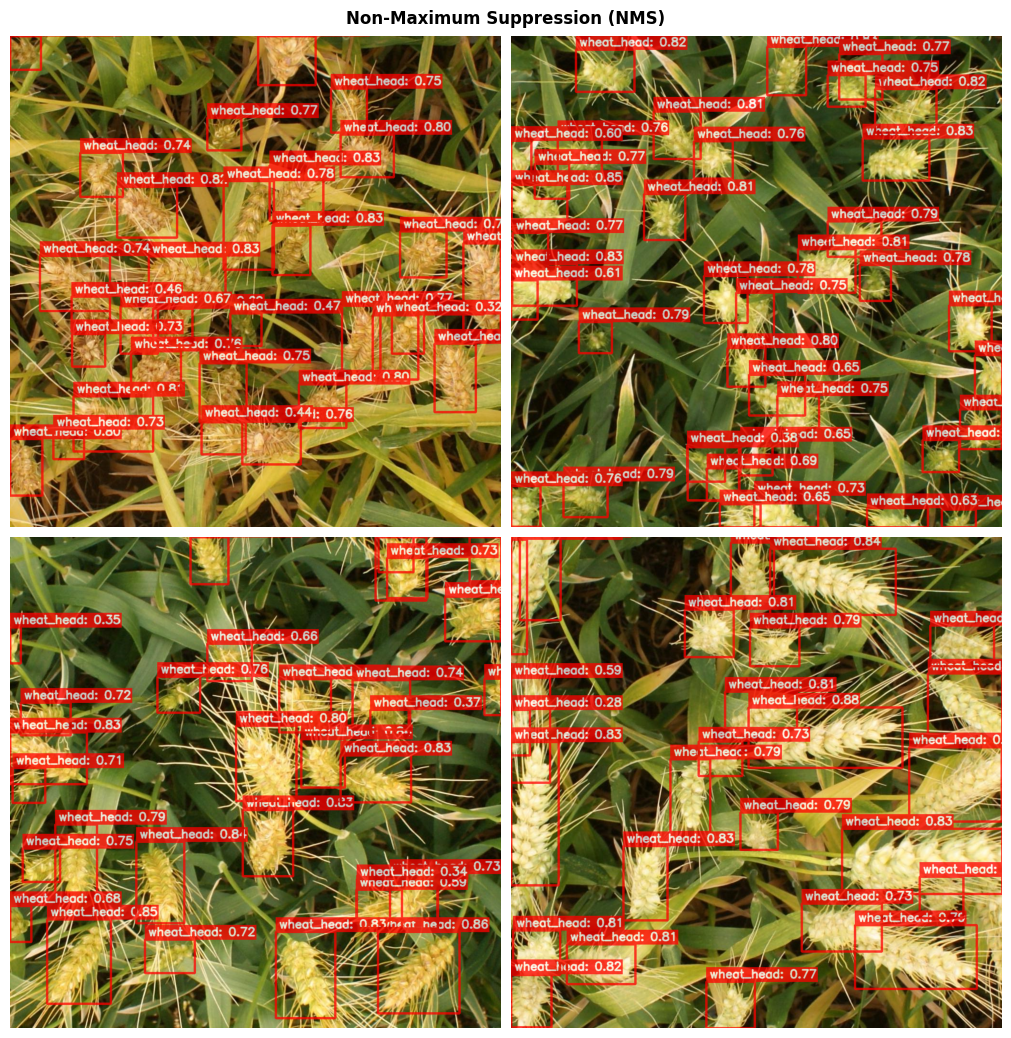

In [ ]:
from itertools import count
visualize_boxes(
    SAMPLE_IMG_DIR,
    sample_img_files,
    boxes_dict_nms,
    scores_dict_nms,
    "Non-Maximum Suppression (NMS)")
print(boxes_dict_nms)
print(scores_dict_nms)

**Inference Results for WBF**

{'f5a1f0358': [[943, 433, 80, 184], [548, 397, 77, 103], [541, 270, 111, 114], [222, 311, 122, 105], [293, 457, 155, 103], [884, 642, 89, 142], [0, 840, 67, 112], [689, 203, 112, 92], [135, 751, 163, 116], [602, 726, 100, 88], [0, 0, 68, 70], [691, 562, 80, 136], [251, 659, 105, 82], [669, 111, 74, 87], [149, 242, 84, 92], [812, 406, 97, 95], [396, 681, 96, 132], [411, 172, 70, 68], [483, 803, 119, 88], [90, 821, 62, 60], [445, 300, 105, 182], [521, 0, 115, 100], [129, 621, 70, 67], [64, 459, 130, 109], [228, 561, 80, 94], [295, 568, 83, 85], [755, 584, 98, 136], [404, 796, 101, 75]], '348a992bb': [[734, 220, 139, 86], [0, 314, 116, 94], [138, 37, 117, 86], [760, 115, 127, 88], [536, 30, 78, 97], [598, 442, 120, 97], [278, 329, 84, 95], [297, 162, 93, 98], [1, 470, 135, 92], [452, 651, 78, 81], [914, 562, 88, 95], [112, 929, 88, 71], [856, 847, 78, 70], [144, 600, 66, 62], [728, 476, 64, 77], [379, 215, 84, 80], [662, 386, 113, 73], [937, 784, 83, 82], [688, 42, 86, 91], [968, 669, 55,

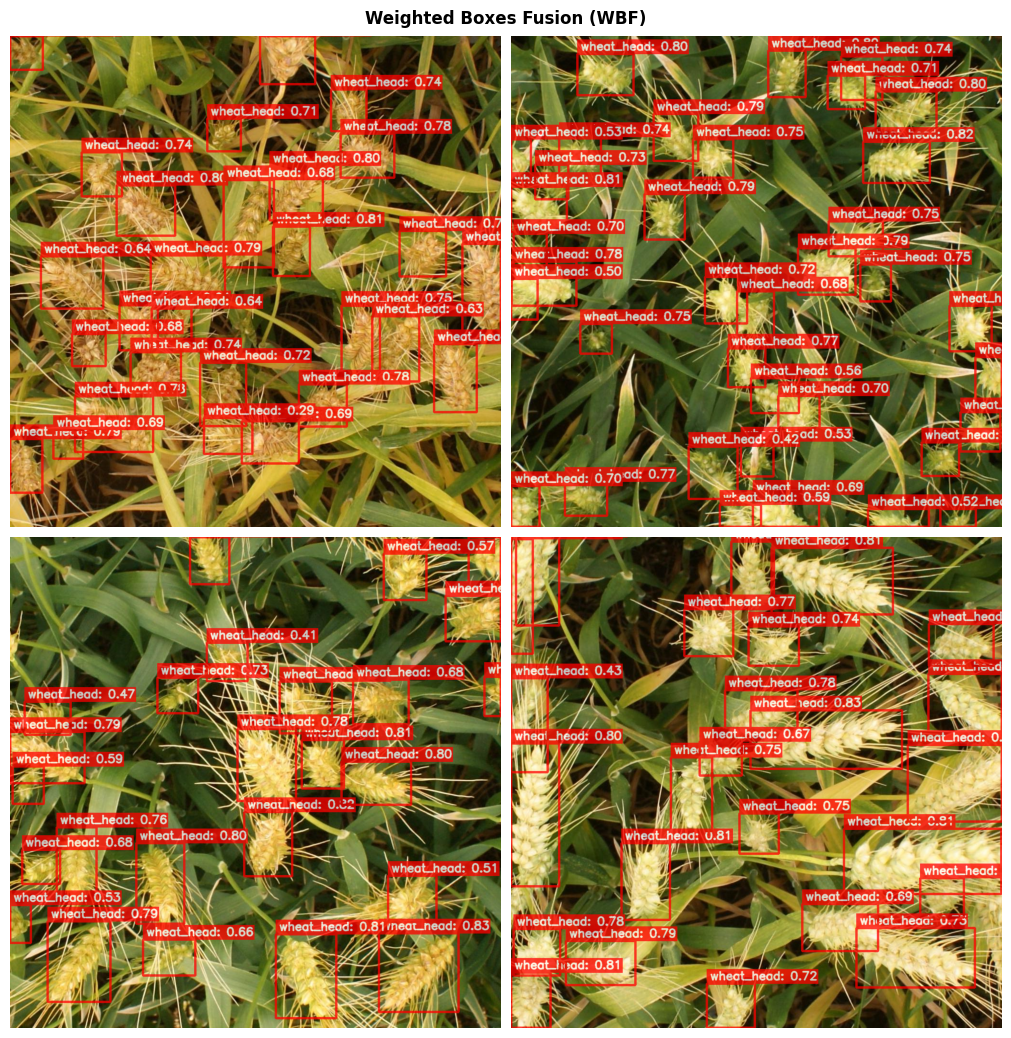

In [ ]:
visualize_boxes(SAMPLE_IMG_DIR,
                sample_img_files,
                boxes_dict_wbf,
                scores_dict_wbf,
                "Weighted Boxes Fusion (WBF)")

print(boxes_dict_wbf)
print(scores_dict_wbf)

In [ ]:
arr1 = [[945, 432, 78, 185], [289, 459, 160, 103], [547, 395, 79, 103], [541, 269, 112, 116], [223, 314, 125, 106], [132, 751, 166, 115], [0, 840, 67, 118], [602, 726, 99, 91], [885, 641, 86, 143], [689, 205, 111, 89], [0, 0, 64, 70], [445, 302, 105, 185], [813, 407, 97, 96], [692, 562, 80, 136], [411, 170, 71, 68], [484, 804, 122, 89], [252, 657, 104, 85], [395, 682, 98, 123], [669, 109, 75, 92], [517, 0, 120, 102], [146, 243, 89, 92], [62, 458, 146, 115], [90, 820, 64, 62], [129, 621, 69, 68], [756, 582, 95, 134], [298, 568, 82, 77], [230, 563, 78, 99], [459, 578, 65, 68], [128, 543, 80, 74], [399, 800, 92, 72], [796, 580, 67, 82]]
print("NMS (Bounding box) -> Image: 'f5a1f0358'", len(arr1))

arr2 = [[943, 433, 80, 184], [548, 397, 77, 103], [541, 270, 111, 114], [222, 311, 122, 105], [293, 457, 155, 103], [884, 642, 89, 142], [0, 840, 67, 112], [689, 203, 112, 92], [135, 751, 163, 116], [602, 726, 100, 88], [0, 0, 68, 70], [691, 562, 80, 136], [251, 659, 105, 82], [669, 111, 74, 87], [149, 242, 84, 92], [812, 406, 97, 95], [396, 681, 96, 132], [411, 172, 70, 68], [483, 803, 119, 88], [90, 821, 62, 60], [445, 300, 105, 182], [521, 0, 115, 100], [129, 621, 70, 67], [64, 459, 130, 109], [228, 561, 80, 94], [295, 568, 83, 85], [755, 584, 98, 136], [404, 796, 101, 75]]
print("WBF (Bounding box)-> Image: 'f5a1f0358'", len(arr2))

conf_arr1 =  [[0.8437700271606445], [0.8327699899673462], [0.8296700119972229], [0.8261600136756897], [0.8154199719429016], [0.8082799911499023], [0.8045799732208252], [0.8019099831581116], [0.7997099757194519], [0.7989699840545654], [0.7960299849510193], [0.7806400060653687], [0.7753099799156189], [0.7674999833106995], [0.7656800150871277], [0.7613999843597412], [0.7587699890136719], [0.7545899748802185], [0.7543299794197083], [0.7522199749946594], [0.7434700131416321], [0.7396100163459778], [0.7329699993133545], [0.7305700182914734], [0.7293400168418884], [0.6881899833679199], [0.6660900115966797], [0.4713599979877472], [0.4584600031375885], [0.4406000077724457], [0.31832000613212585]]
print("NMS (Confidence score)-> Image: 'f5a1f0358'", len(conf_arr1))

conf_arr2 =  [[0.83158], [0.80976], [0.80252], [0.79508], [0.79416], [0.7908], [0.78688], [0.78364], [0.78274], [0.77516], [0.75027], [0.74762], [0.74418], [0.74408], [0.74091], [0.73563], [0.7167], [0.71365], [0.69481], [0.68631], [0.68161], [0.68106], [0.67515], [0.63939], [0.63754], [0.63613], [0.63331], [0.2861]]
print("WBF (Confidence score)-> Image: 'f5a1f0358'", len(conf_arr2))

arr3 = [[1, 310, 116, 93], [2, 475, 135, 87], [534, 22, 81, 101], [733, 213, 139, 88], [759, 110, 128, 91], [135, 28, 122, 88], [598, 444, 120, 91], [277, 329, 86, 96], [297, 157, 98, 99], [451, 650, 79, 81], [109, 928, 92, 75], [936, 778, 87, 83], [141, 596, 69, 65], [913, 561, 89, 96], [858, 842, 76, 67], [660, 386, 112, 74], [402, 500, 91, 98], [727, 477, 65, 75], [684, 37, 90, 95], [3, 410, 74, 68], [49, 266, 72, 73], [967, 665, 57, 88], [97, 206, 92, 76], [381, 219, 81, 78], [0, 938, 61, 85], [469, 535, 79, 88], [660, 81, 79, 66], [555, 750, 87, 85], [507, 958, 133, 66], [898, 987, 71, 37], [408, 901, 68, 68], [368, 857, 107, 111], [478, 845, 67, 71], [435, 976, 85, 48], [496, 706, 117, 85], [742, 984, 127, 40], [0, 509, 55, 82], [0, 218, 42, 83], [367, 853, 79, 76]]
print("NMS (Bounding box) -> Image: '348a992bb'", len(arr3))

arr4 = [[734, 220, 139, 86], [0, 314, 116, 94], [138, 37, 117, 86], [760, 115, 127, 88], [536, 30, 78, 97], [598, 442, 120, 97], [278, 329, 84, 95], [297, 162, 93, 98], [1, 470, 135, 92], [452, 651, 78, 81], [914, 562, 88, 95], [112, 929, 88, 71], [856, 847, 78, 70], [144, 600, 66, 62], [728, 476, 64, 77], [379, 215, 84, 80], [662, 386, 113, 73], [937, 784, 83, 82], [688, 42, 86, 91], [968, 669, 55, 89], [100, 210, 87, 76], [50, 268, 69, 72], [404, 502, 88, 97], [660, 82, 78, 70], [0, 938, 59, 85], [5, 412, 69, 67], [557, 750, 86, 83], [504, 956, 138, 67], [471, 532, 77, 92], [895, 986, 74, 37], [435, 977, 86, 46], [500, 713, 100, 73], [479, 845, 68, 73], [0, 215, 41, 86], [744, 986, 127, 37], [0, 506, 55, 85], [370, 856, 102, 109]]
print("WBF (Bounding box)-> Image: '348a992bb'", len(arr4))

NMS (Bounding box) -> Image: 'f5a1f0358' 31
WBF (Bounding box)-> Image: 'f5a1f0358' 28
NMS (Confidence score)-> Image: 'f5a1f0358' 31
WBF (Confidence score)-> Image: 'f5a1f0358' 28
NMS (Bounding box) -> Image: '348a992bb' 39
WBF (Bounding box)-> Image: '348a992bb' 37


## **Intersection Over Union**

**1. Numpy**

In [ ]:
import numpy as np
np.__version__

'1.23.5'

**Define Function to calculate IoU**

In [ ]:
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1

    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou

**Bounding Box Co-ordinates**

In [ ]:
ground_truth_bbox = np.array([1202, 123, 1650, 868], dtype=np.float32)

prediction_bbox = np.array([1162.0001, 92.0021, 1619.9832, 694.0033], dtype=np.float32)

In [ ]:
iou = get_iou(ground_truth_bbox, prediction_bbox)
print('IOU: ', iou)

IOU:  0.6441399913136432


**2. PyTorch**

2.1. In-Built Function

In [ ]:
# Import dependencies.
import torch
from torchvision import ops

# Bounding box coordinates.
ground_truth_bbox = torch.tensor([[1202, 123, 1650, 868]], dtype=torch.float)
prediction_bbox = torch.tensor([[1162.0001, 92.0021, 1619.9832, 694.0033]], dtype=torch.float)

# Get iou.
iou = ops.box_iou(ground_truth_bbox, prediction_bbox)
print('IOU : ', iou.numpy()[0][0])

IOU :  0.6436676


2.2. Using custom function

In [ ]:
import torch
torch.__version__

'2.1.0+cu118'

In [ ]:
def get_iou_torch(ground_truth, pred):
    # Coordinates of the area of intersection.
    ix1 = torch.max(ground_truth[0][0], pred[0][0])
    iy1 = torch.max(ground_truth[0][1], pred[0][1])
    ix2 = torch.min(ground_truth[0][2], pred[0][2])
    iy2 = torch.min(ground_truth[0][3], pred[0][3])

    # Intersection height and width.
    i_height = torch.max(iy2 - iy1 + 1, torch.tensor(0.))
    i_width = torch.max(ix2 - ix1 + 1, torch.tensor(0.))

    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    gt_height = ground_truth[0][3] - ground_truth[0][1] + 1
    gt_width = ground_truth[0][2] - ground_truth[0][0] + 1

    # Prediction dimensions.
    pd_height = pred[0][3] - pred[0][1] + 1
    pd_width = pred[0][2] - pred[0][0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou

In [ ]:
ground_truth_bbox = torch.tensor([[1202, 123, 1650, 868]], dtype=torch.float)

prediction_bbox = torch.tensor([[1162.0001, 92.0021, 1619.9832, 694.0033]], dtype=torch.float)


In [ ]:
iou_val = get_iou_torch(ground_truth_bbox, prediction_bbox)
print('IOU : ', iou_val.numpy())

IOU :  0.64413995
